In [1]:
# imports
import collections
import math
import heapq
import numpy as np
import itertools as it
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from collections import deque
from itertools import cycle


# Compare Almost Symmetry Runtimes

# DegreeDiffElim

In [2]:
def DegreeDiffElim(G_A,P_A,kA):
    edges = list(P_A.edges())
    for e in edges:
        if abs(G_A.degree(e[0]) - G_A.degree(e[1])) > kA:
            P_A.remove_edge(*e)
    return P_A

# FixedDegElim

In [3]:
def FixedDegElim(G_A,P_A,Ef_A):
    edges = list(P_A.edges())
    for e in edges:
        if Ef_A.degree(e[0]) > G_A.degree(e[1]):
            P_A.remove_edge(*e)
    return P_A

# Build Cost Matrix Helper Functions

In [4]:
def print_independence(v,i,j,G_A):
    edge,Ni,Nj = pair2neighborhood(G_A,1,2)
    _i = edge[0]
    _j = edge[1]
    print(Ni)
    print(f"Neighborhood of {_i} is {Ni}")
    for _ni in nx.neighbors(G_A,_i):
        print(_ni)
    print(f"Neighborhood of {_j} is {Nj}")
    for _nj in nx.neighbors(G_A,_j):
        print(_nj)
    print("------")
    niUnj = Ni | Nj
    for _e in niUnj:print(_e)

    print(f"Ni union Nj: {niUnj}")
    Nv = set(nx.neighbors(G_A,v))
    print(f"Neighborhood of v: {Nv}")
    _intersection = niUnj.intersection(Nv) 
    print(f"Intersection of Nv and Ni U Nj: {_intersection}")
    print(_intersection)

#  Vertex independence: used in weight assignment

In [5]:
# check independence 
#
def vertex_independent_from(v,i,j,G_A):
    edge,Ni,Nj = pair2neighborhood(G_A,i,j)
    _i = edge[0]
    _j = edge[1]
    #print("------")
    niUnj = Ni | Nj
    #for _e in niUnj:print(_e)
    #print(f"Ni union Nj: {niUnj}")
    Nv = set(nx.neighbors(G_A,v))
    #print(f"Neighborhood of v: {Nv}")
    _intersection = niUnj.intersection(Nv) 
    #print(f"Intersection of Nv and Ni U Nj: {_intersection}")
    #print(_intersection)
    return not bool(_intersection)

In [6]:
# larger neighborhood should be Ni (line 6 in DKAS)
# larger neighborhood should be on left
def sortByLength(set1,set2):
    if len(set1) == len(set2):
        return set1, set2
    elif len(set1) > len(set2):
        return set1, set2
    else:
        return set2,set1

# Assign Weights to mappings: ensures neighborhoods matched together. 

In [7]:
# mostly as written in DASG paper
# page 8, lines 10-20
#
#
# cost in terms of 'degrees decremented / half-edges removed'
def assign_weight_k1(e,i,j,G_A,P_A,k_A):
    u = e[0]
    v = e[1]
    # mapping to self has 0 cost
    if u == v:
        return 0
    #print("assigning weight",e)
    degu = G_A.degree(u)
    degv = G_A.degree(v)
    # elif because only one neighborhood is being decremented.
    if u in (i,j):
        degu = max(degu - k_A,0)
    elif v in (i,j):
        degv = max(degv - k_A,0)
    # if mapping being tested coincides with edge. 
    if e == (i,j) or e == (j,i):
        #print(f"edge {e} being weighted is mapping {i},{j} being tested")
        return 0
    #
    if (u,v) in P_A.edges() or (v,u) in P_A.edges():
        #print(f"{e} in {P_A.edges()}?")
        #cost tightened here
        if degu > degv and vertex_independent_from(u,i,j,G_A):
            #print(f"{e} satisfies FIRST 1 clause!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            return -2*(degu - degv)
        elif degv > degu and vertex_independent_from(v,i,j,G_A):
            #print(f"{e} satisfies SECOND 2 clause!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            return -2*(degv - degu)
        else:
            #print(f"{e} satisfies THIRD 3 clause")
            return -abs(degu - degv)
    else:
        return -math.inf

In [8]:
# this is for d2v and v2d
def assign_weight_k2(neighbor,dummy_parent,Ef_A):
    edge = (neighbor,dummy_parent)
    if edge in Ef_A.edges():
        return -math.inf
    else: return -2

In [9]:
# returns python set of integers, sorted by length
def pair2neighborhood(g,i,j):
    N_i = set((e for e in nx.neighbors(g,i)))
    N_j = set((f for f in nx.neighbors(g,j)))
    #
    Ni,Nj = sortByLength(N_i,N_j)
    if g.degree(i) < g.degree(j):
        _i = j
        _j = i
    else:
        # no exchange
        _i = i
        _j = j
    #
    edge = (_i,_j)
    return edge, Ni,Nj

# Build Cost Matrix

In [10]:
# build-cost-matrix using python set
def BuildCostMatrix(i,j,G_A,P_A,Ef_A,k_A):
    _edge, _Ni_int,_Nj_int = pair2neighborhood(G_A,i,j)
# initialize    
    CostMatrix = nx.Graph()
    degDiff = abs(G_A.degree(i) - G_A.degree(j))
    Ni = []
    Nj = []
    xi = []
    xj = []
    _i = _edge[0]
    _j = _edge[1]
    # swap j and i in order to consistently refer to larger set on left
    if G_A.degree(i) < G_A.degree(j):
        _i = j
        _j = i
    else:
        # no exchange
        _i = i
        _j = j
    
    
# make vertices
##
## dummy: used for edge deletion
## parent: used in weight assignment logic
## value: used in updating permutation graph
##
    for e in _Ni_int:
        name = "i" + str(e)
        Ni.append(name)
        CostMatrix.add_node(name,bipartite=0,dummy=False,parent=_i,value=e)
    for f in _Nj_int:
        name = "j" + str(f)
        Nj.append(name)
        CostMatrix.add_node(name,bipartite=1,dummy=False,parent=_j,value=f)
        
    #print(f"vertices for Ni: {Ni}")
    #print(f"vertices for Nj: {Nj}")
    
# # larger set xi goes in right partition of graph as indicated by 'bipartite' parameter
    for xe in range(1,degDiff+k_A):
        name = "xi" + str(xe)
        xi.append(name)
        CostMatrix.add_node(name,bipartite=1,dummy=True,parent=_i,value=_i)
    for xf in range(1,k_A):
        name = "xj" + str(xf)
        xj.append(name)
        CostMatrix.add_node(name,bipartite=0,dummy=True,parent=_j,value=_j)
        
    #print(f"xi: {xi}")
    #print(f"xj: {xj}")
    
# make edges (weights negated)
    value = nx.get_node_attributes(CostMatrix,'value') # used for permutation graph update
    parent = nx.get_node_attributes(CostMatrix,'parent') # used for weight assignment
# # vertex to vertex
    V2V = []
    for e0 in it.product(Ni,Nj):
        _edge0 = (value[e0[0]],value[e0[1]])
        weight = assign_weight_k1(_edge0,i,j,G_A,P_A,k_A)
        #print(f" {_edge0} assigned weight: {weight} ")
            
        #print(f" vertex to vertex (Ni cross Nj): {e0} ;weight: {weight}")
        V2V.append((*e0,weight))
        
# # vertex to dummy
    D2V = []
# # #"draw an edge between vj and xj"
    for e1 in it.product(xj,Nj):
        weight = assign_weight_k2(value[e1[1]],parent[e1[0]],Ef_A)
        #print(f" dummy to vertex (xj cross Nj): {e1} ;weight: {weight}")
        D2V.append((*e1,weight))
    
    V2D = []
# # #"draw an edge between ui and xi"
    for e2 in it.product(Ni,xi):
        weight = assign_weight_k2(value[e2[0]],parent[e2[1]],Ef_A)
        #print(f" vertex to dummy (Ni cross xi): {e2} ;weight: {weight}")
        D2V.append((*e2,weight))

# # dummy to dummy
    D2D = []
    for e3 in it.product(xj,xi):
        #print(f"dummy to dummy {e3}")
        D2D.append((*e3,0))

# add weighted edges
    CostMatrix.add_weighted_edges_from(V2V)
    CostMatrix.add_weighted_edges_from(D2V)
    CostMatrix.add_weighted_edges_from(V2D)
    CostMatrix.add_weighted_edges_from(D2D)
# display
    #l,r = bipartite.sets(CostMatrix)
    #print(f"bipartite.sets left set {l}")
    #print(f"bipartite.sets right set {r}")
    return CostMatrix 

# HungarianSolve: find cost perfect matching

In [11]:
# 
# draw bipartite graph
#
def plot_cost_matrix(CostMatrix):
    l,r = bipartite.sets(CostMatrix)
    pos = dict()
    pos.update( (nn, (1, ii)) for ii, nn in enumerate(l) ) # put nodes from X at x=1
    pos.update( (nn, (2, ii)) for ii, nn in enumerate(r) ) # put nodes from Y at x=2
    nx.draw(CostMatrix, pos=pos,with_labels=True)
    #edge weights
    labels = nx.get_edge_attributes(CostMatrix, "weight")
    nx.draw_networkx_edge_labels(CostMatrix, pos=pos, edge_labels=labels)
    print("edge weights")
    for w in labels:
        print(f"edge: {w} -- weight: {labels[w]}")
    plt.show()
    

In [12]:
# HungarianSolve from page 9 of detect-almost-symmetries
# calculates the sum of the weights in the matching
def HungarianSolve(CostMatrix):
    cost = 0
    deleteEdges = []
    #
    # draw bipartite graph
    #
    #plot_cost_matrix(CostMatrix)
    
    #
    # Solve Cost Perfect Matching problem
    #
    Matching = nx.max_weight_matching(CostMatrix,maxcardinality=True)
    #print(f"is perfect matching: {nx.is_perfect_matching(CostMatrix,Matching)}")
    #print(f"MATCHING: {Matching}")
    
    #
    # cost initialize, and ensure that weight of i - j is 0 in costMatrix
    #
    dummy = nx.get_node_attributes(CostMatrix,"dummy")
    value = nx.get_node_attributes(CostMatrix,"value")
    parent = nx.get_node_attributes(CostMatrix,"parent")
    _re = list(CostMatrix.edges())[0]
    _p1 = parent[_re[0]]
    _v1 = value[_re[0]]
    _p2 = parent[_re[1]]
    _v2 = value[_re[1]]
    #print(f"RANDOM EDGE: {_re}, edge parents: {_p1},{_p2} ")
    #cost = abs(nx.degree(G_A,_v1) - nx.degree(G_A,_v2))
    #
    # for each pair in optimal assignment, extract edges which correspond to edge deletions, and sum the cost. 
    #
    for m in Matching:
        i = m[0]
        j = m[1]
        #
        #
        # 'ui is dummy T/F?' XOR 'j is dummy T/F?'
        #
        # "From the solution we determine when an edge {ui, xi} or {vj, xj}
        # is in the optimal assignment. The former corresponds to the deletion of edge {i, u} in
        # GA, the later to the deletion of edge {j, v}."
        #
        #print("assignment: ",m,CostMatrix[i][j]['weight'])
        if dummy[i] ^ dummy[j]:
            #print(f"encoded edge: {m}")
            #print(f"value dict conversion: value[i] = {value[i]}, value[j] = {value[j]}")
            #
            # update cost, deleteEdges
            # cost multiplied by -1 here.
            deleteEdges.append((value[i],value[j]))
        cost +=-1*CostMatrix[i][j]['weight']
            
    return cost,deleteEdges

# Shared Logic Above

# REFINEMENT 1: Refine By Matching

In [13]:
#
def RefineByMatching(G_A,P_A,Ef_A,k_A):
    #
    #possibleMappings = {}
    edgeUse = {}
    for e in G_A.edges():
        #print("G_A edges: ",e)
        edgeUse[e] = 0
    EP_A = list(P_A.edges())
    #
    #print("for edge in E(P_A)")
    count = 0
    for edge in EP_A:
        i = edge[0]
        j = edge[1]
        
        count+=1
        CostMatrix = BuildCostMatrix(i,j,G_A,P_A,Ef_A,k_A)
        cost,deleteEdges = HungarianSolve(CostMatrix)
        
        if edge ==(1,27):
            print(f"*****************  Mapping Test : {i} --> {j}  *****************")
            #print(f"G_A = {G_A.edges()}")
            print(np.matrix(nx.adjacency_matrix(P_A)))
            print(f"k_A = {k_A}, 2*k_A = {2*k_A}")
            print(f" deg {i} in G_A {G_A.degree(i)}")
            print(f" deg {j} in G_A {G_A.degree(j)}")
            print(f"cost = {cost}")
            print(f" + + + count subtotal: {count}")
            plot_cost_matrix(CostMatrix)
        if cost > 2*k_A:
            #print(f" **** **** **** Mapping {i} --> {j} proven impossible **** **** **** ")
            #possibleMappings[edge] = "edge removed"
            if edge == (1,27):
                print(f" {edge} deleted with cost {cost}, at budget {2*k_A}")
            P_A.remove_edge(*edge)
            #print(f" - - - edge popped: {edge}")
        else: continue
            #possibleMappings[edge] = deleteEdges
            #for _e in deleteEdges:
            #    e = tuple(sorted(_e))
            #    edgeUse[e] = edgeUse[e]+1
    #print(edgeUse)
    #print(f"before: {EP_A}")
    #print(f"after: {P_A.edges()}")
    return P_A,count

# Algorithm 1 redraft below

In [14]:
def Algorithm1(G,k):
    # dummy graph
    Ef = nx.Graph()
    Ef.add_nodes_from(G.nodes())
    # initial refinement via degree-diff-elim removes mappings whose degree
    # difference renders them impossible
    P = nx.complete_graph(G.nodes())
    P = DegreeDiffElim(G,P,k)
    
    #
    _E = len(P.edges())
    P,count = RefineByMatching(G,P,Ef,k)
    
    #
    delta = abs(_E - len(P.edges()))
    # Continue to apply RefineByMatching while P is changed
    while delta != 0:
        _E = len(P.edges())
        P,subtotal = RefineByMatching(G,P,Ef,k)
        count+=subtotal
        delta = abs(_E - len(P.edges()))
    
    #
    P_stack = list(P.edges())
    return P,P_stack,count



# Algo 1 redraft above

# Algo 2 redraft below

# Refinement 2

In [15]:
def jim_elim_update_adjacent_bounds(i,j,G_A,Pbar,P_stack):
    #
    set_stack = set(P_stack)
    Ni = set(nx.neighbors(G_A,i))
    Nj = set(nx.neighbors(G_A,j))
    _ee = set(it.product(Ni,Nj))
    # NiXNj : All mapping-pairs implied by matching problem on i,j
    #
    # edges always sorted
    NiXNj = set( tuple(sorted(edge)) for edge in it.product(Ni,Nj))
    #
    # only consider those mappings unproven in P
    NiXNj_intersect_P = set_stack.intersection(NiXNj)
    #
    for l,k in NiXNj_intersect_P:
        deg_l = G_A.degree(l)
        deg_k = G_A.degree(k)
        # worst case is 4, best case zero, 
        # if degreediff 0, then 
        delta_bound = max(0,4-abs(deg_l - deg_k))
        if i in nx.neighbors(G_A,l) and j in nx.neighbors(G_A,k):
            Pbar[(l,k)] = Pbar[(l,k)] + delta_bound
        elif j in nx.neighbors(G_A,l) and i in nx.neighbors(G_A,k):
            Pbar[(l,k)] = Pbar[(l,k)] + delta_bound

In [16]:
# first pass: returns T,stack
# T: number of mappings under budget after single pass
# Pbar: stack of edges under budget after single pass
def jim_elim_initialize1(G_A,Ef_A,k_A):
    # complete graph
    P = nx.complete_graph(G_A.nodes())
    P = DegreeDiffElim(G,P,k)
    # weights init 0. This will be overwritten in next loop.
    Pbar = {e:0 for e in it.combinations(G_A.nodes(),2) }

    # cost perfect matching solved for every pair, and bounds updated.
    # P is updated as well. 
    count = 0
    elist_first_pass = list(P.edges())
    for e in elist_first_pass:
        i = e[0]
        j = e[1]
        # solve matching on i,j
        count+=1
        CostMatrix = BuildCostMatrix(i,j,G_A,P,Ef_A,k_A)
        cost,deleteEdges = HungarianSolve(CostMatrix)
        if cost <= 2*k_A:
            # assign weight to edge
            Pbar[e] = cost
        else:
            # always over budget (mapping never possible) when cost computed to be overbudget
            Pbar[e] = -1*math.inf
            P.remove_edge(*e)
            # we only consider mappings unproven in P
            jim_elim_update_adjacent_bounds(i,j,G_A,Pbar,deque(P.edges()))
    
    # Stack of Edges
    P_stack = deque(P.edges())
    # Pbar - upperbound cost of mapping (dynamic)
    
    # at this point we have eleminated some mappings, but the costs are dynamic
    # so we must revisit the mappings, and recompute the costs, We want to do this
    # in a manner which minimizes the number of times we must construct the 
    # cost matrix.
    
    # We will maintain 3 data structures
    # P is a graph object representing unproven mappings
    # P_stack is the stack of edges present in P
    # Pbar_ij is most expensive known cost associated with ij in P. 
    # Pbar_ij = inf, indicates it is impossible
    # We cannot use a typical adjacency matrix because zero here is
    # zero is mapped to infinity.
    # a weight we want to distinguish from the absence of a vertex as in P.
    
    return P,P_stack,Pbar,count

In [17]:
#  P_stack
#  max pbar [][][].....[][][][] min pbar
#
#
def sort_P_stack_by_ub(P_stack,Pbar):
    _tmp_stack_list = list(P_stack)
    _tmp_stack_list.sort(key=lambda e:Pbar[e],reverse=True)
    return deque(_tmp_stack_list)

In [18]:
def jim_elim_while1(G_A,Ef_A,k_A):
    # initial push, to eliminate mappings in P/P_stack, 
    # and compute initial weights Pbar which are the worst-known cost of mapping edge in P
    P,P_stack,Pbar,count_init = jim_elim_initialize1(G_A,Ef_A,k_A)
    # track the number of times that bcm is called
    count = count_init
    #  P_stack:
    #
    #  first [][][][]...[][][] last
    #
    #
    while P_stack:
        
        # Unpack edge at top of stack
        e = P_stack.popleft()
        i =  e[0]
        j = e[1]
        Pbar_ij = Pbar[e]
        #
        
        # see if the upperbound of cost is over budget
        if Pbar_ij >= 2*k_A:
            #### compute matching score and update bounds + P/P_stack if budget exceeded
            # P graph is necessary here
            count+=1
            CostMatrix = BuildCostMatrix(i,j,G_A,P,Ef_A,k_A)
            true_cost, deleteEdges = HungarianSolve(CostMatrix)
            if (e == (1,27)) ^ (e == (20,30)):
                print(f" algo2 cost of {e}: {true_cost}")
            
            # see if true_cost is under budget
            if true_cost <= 2*k_A:
                # tighten bound Pbar_ij for e = (i,j)
                Pbar[e] = true_cost
                # return 'e' to back of stack for future potential testing
                P_stack.append(e)
            #
            else:
                # eliminate from P
                P.remove_edge(*e)
                # update Pbar
                Pbar[e] = -1*math.inf
                # accepts Pbar as argument and stack_P (converted to set)
                # Pbar updated as side effect.
                jim_elim_update_adjacent_bounds(i,j,G_A,Pbar,P_stack)
                #
                # 'e' is not returned to stack_P
                
        #   
        else:
            #### do not compute matching score, return edge to stack
            ##### then, reorder stack by weight, so higher 
            #### priority edges can be tested and removed (ideally) early, resulting in 
            #### fewer calls later on in program execution;
            #### also check halting condition here
            P_stack.appendleft(e)
            #
            P_stack = sort_P_stack_by_ub(P_stack,Pbar)
            # max 'upperbound of matching score' in Pbar
            
            max_Pbar_ij = Pbar[P_stack[0]]
            if max_Pbar_ij <= 2*k_A:
                for e in P_stack:
                    print(f" edge -> weight : {e} - {Pbar[e]}")
                # halt program, because the maximum worst cast cost for P is at or below 
                # budget.
                print(f"ub of (1,27) at halt: {Pbar[(1,27)]}")
                print(f"ub of (20,30) at halt: {Pbar[(20,30)]}")
                return P,P_stack,Pbar,count
    #
    return P,P_stack,Pbar,count
                
            
            
    

In [19]:
def Algorithm2(G,k):
    Ef = nx.Graph()
    Ef.add_nodes_from(G.nodes())
    P,P_stack,Pbar,count = jim_elim_while1(G,Ef,k)
    return P,P_stack,Pbar,count
    

# Algo 2 redraft above

# Test Driver 

In [20]:
### init graph

#n = 25
#k = 1
#_noderange = range(1,n+1)
#
#G = nx.Graph()
#Ef = nx.Graph()
#G.add_nodes_from(_noderange)
#Ef.add_nodes_from(G.nodes())
#G.add_edges_from([(4,5),(3,2),(4,3),(5,2),(6,4),(1,5),(1,2),(2,7),(1,3)])
#ran = nx.erdos_renyi_graph(n,0.7)
#for i,j in ran.edges():
#    G.add_edges_from([(i+1,j+1)])

#nx.draw(G,with_labels=True,font_weight='bold')
#plt.show()
### #### 
#
# Algo 1
#P1,P_stack1,count1 = Algorithm1(G,k)
#
### ###
#print("algo1 : P final ")
#print(np.array(nx.adjacency_matrix(P1).todense()))
#for e in P_stack1:
#    print(e)

#print("\n\n # # # # # \n\n")

########################################################

### ###
#
# Algo 2
# test initialization
#P2,P_stack2,Pbar,count_init = jim_elim_initialize1(G,Ef,k)
#
#for e in P_stack2:
#    if Pbar[e] == math.inf:
#        raise Exception("Pbar or P_stack not properly constructed")
#
#if not len(P2.edges()) == len(P_stack2):
#    raise Exception("P or P_stack not properly constructed")

# test elimination loop
#P2,P_stack2,Pbar,count2 = Algorithm2(G,k)
#print("algo2 : P final ")
#print(np.array(nx.adjacency_matrix(P2).todense()))

#for e1,e2 in it.zip_longest(Pbar,sorted(P_stack2)):
#    if Pbar[e] != math.inf:
#        print(f"Pbar edge : weight --> {e1[0]},{e1[1]: <5}{Pbar[e1]: ^5} | P_stack {e2}")

#
# print results
#print(" # # # \n\n")
#if not len(P1.edges()) == len(P2.edges()):
#    print(P1.edges())
#    print(P2.edges())
#    raise Exception("Refinement logic broken")

#if not len(P1.edges()) == len(P_stack1):
#    raise Exception("P1 not synced with P_stack1")

#print(f" algo1 edges remaining: {len(P1.edges())}")

#print(f" algo1 matchings performed: {count1}\n")

#if not len(P2.edges()) == len(P_stack2):
#    raise Exception("P2 not synced with P_stack2")

#print(f" algo2 edges remaining {len(P2.edges())}")

#print(f" algo2 matchings performed: {count2} = initial {count_init} + loop {abs(count2 - count_init)}")



# redraft above

n 40
k 3


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


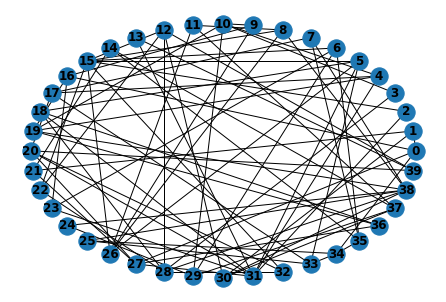

 Edges prior : 780.0
*****************  Mapping Test : 1 --> 27  *****************
[[<40x40 sparse matrix of type '<class 'numpy.int64'>'
	with 1380 stored elements in Compressed Sparse Row format>]]
k_A = 3, 2*k_A = 6
 deg 1 in G_A 3
 deg 27 in G_A 5
cost = 5
 + + + count subtotal: 62
edge weights
edge: ('i0', 'j0') -- weight: 0
edge: ('i0', 'j21') -- weight: -2
edge: ('i0', 'j30') -- weight: 0
edge: ('i0', 'xi1') -- weight: -2
edge: ('i0', 'xi2') -- weight: -2
edge: ('i0', 'xi3') -- weight: -2
edge: ('i0', 'xi4') -- weight: -2
edge: ('i36', 'j0') -- weight: -2
edge: ('i36', 'j21') -- weight: 0
edge: ('i36', 'j30') -- weight: -2
edge: ('i36', 'xi1') -- weight: -2
edge: ('i36', 'xi2') -- weight: -2
edge: ('i36', 'xi3') -- weight: -2
edge: ('i36', 'xi4') -- weight: -2
edge: ('i20', 'j0') -- weight: -1
edge: ('i20', 'j21') -- weight: -2
edge: ('i20', 'j30') -- weight: -1
edge: ('i20', 'xi1') -- weight: -2
edge: ('i20', 'xi2') -- weight: -2
edge: ('i20', 'xi3') -- weight: -2
edge: ('i20',

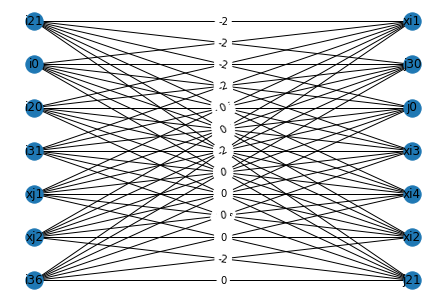

*****************  Mapping Test : 1 --> 27  *****************
[[<40x40 sparse matrix of type '<class 'numpy.int64'>'
	with 960 stored elements in Compressed Sparse Row format>]]
k_A = 3, 2*k_A = 6
 deg 1 in G_A 3
 deg 27 in G_A 5
cost = 5
 + + + count subtotal: 50
edge weights
edge: ('i0', 'j0') -- weight: 0
edge: ('i0', 'j21') -- weight: -2
edge: ('i0', 'j30') -- weight: 0
edge: ('i0', 'xi1') -- weight: -2
edge: ('i0', 'xi2') -- weight: -2
edge: ('i0', 'xi3') -- weight: -2
edge: ('i0', 'xi4') -- weight: -2
edge: ('i36', 'j0') -- weight: -inf
edge: ('i36', 'j21') -- weight: -inf
edge: ('i36', 'j30') -- weight: -inf
edge: ('i36', 'xi1') -- weight: -2
edge: ('i36', 'xi2') -- weight: -2
edge: ('i36', 'xi3') -- weight: -2
edge: ('i36', 'xi4') -- weight: -2
edge: ('i20', 'j0') -- weight: -1
edge: ('i20', 'j21') -- weight: -2
edge: ('i20', 'j30') -- weight: -1
edge: ('i20', 'xi1') -- weight: -2
edge: ('i20', 'xi2') -- weight: -2
edge: ('i20', 'xi3') -- weight: -2
edge: ('i20', 'xi4') -- weig

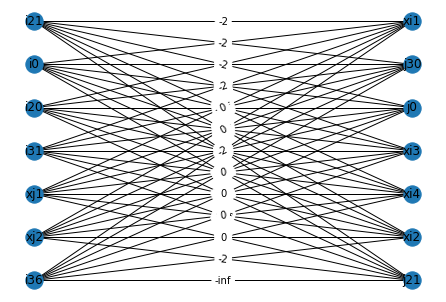

*****************  Mapping Test : 1 --> 27  *****************
[[<40x40 sparse matrix of type '<class 'numpy.int64'>'
	with 894 stored elements in Compressed Sparse Row format>]]
k_A = 3, 2*k_A = 6
 deg 1 in G_A 3
 deg 27 in G_A 5
cost = 5
 + + + count subtotal: 44
edge weights
edge: ('i0', 'j0') -- weight: 0
edge: ('i0', 'j21') -- weight: -2
edge: ('i0', 'j30') -- weight: 0
edge: ('i0', 'xi1') -- weight: -2
edge: ('i0', 'xi2') -- weight: -2
edge: ('i0', 'xi3') -- weight: -2
edge: ('i0', 'xi4') -- weight: -2
edge: ('i36', 'j0') -- weight: -inf
edge: ('i36', 'j21') -- weight: -inf
edge: ('i36', 'j30') -- weight: -inf
edge: ('i36', 'xi1') -- weight: -2
edge: ('i36', 'xi2') -- weight: -2
edge: ('i36', 'xi3') -- weight: -2
edge: ('i36', 'xi4') -- weight: -2
edge: ('i20', 'j0') -- weight: -1
edge: ('i20', 'j21') -- weight: -2
edge: ('i20', 'j30') -- weight: -1
edge: ('i20', 'xi1') -- weight: -2
edge: ('i20', 'xi2') -- weight: -2
edge: ('i20', 'xi3') -- weight: -2
edge: ('i20', 'xi4') -- weig

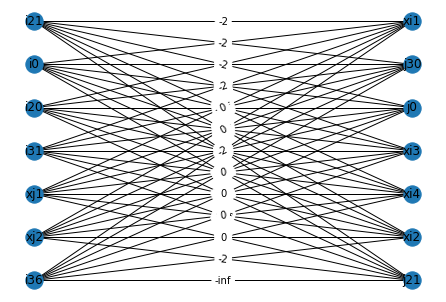

*****************  Mapping Test : 1 --> 27  *****************
[[<40x40 sparse matrix of type '<class 'numpy.int64'>'
	with 868 stored elements in Compressed Sparse Row format>]]
k_A = 3, 2*k_A = 6
 deg 1 in G_A 3
 deg 27 in G_A 5
cost = 8
 + + + count subtotal: 43
edge weights
edge: ('i0', 'j0') -- weight: 0
edge: ('i0', 'j21') -- weight: -2
edge: ('i0', 'j30') -- weight: 0
edge: ('i0', 'xi1') -- weight: -2
edge: ('i0', 'xi2') -- weight: -2
edge: ('i0', 'xi3') -- weight: -2
edge: ('i0', 'xi4') -- weight: -2
edge: ('i36', 'j0') -- weight: -inf
edge: ('i36', 'j21') -- weight: -inf
edge: ('i36', 'j30') -- weight: -inf
edge: ('i36', 'xi1') -- weight: -2
edge: ('i36', 'xi2') -- weight: -2
edge: ('i36', 'xi3') -- weight: -2
edge: ('i36', 'xi4') -- weight: -2
edge: ('i20', 'j0') -- weight: -inf
edge: ('i20', 'j21') -- weight: -2
edge: ('i20', 'j30') -- weight: -inf
edge: ('i20', 'xi1') -- weight: -2
edge: ('i20', 'xi2') -- weight: -2
edge: ('i20', 'xi3') -- weight: -2
edge: ('i20', 'xi4') -- 

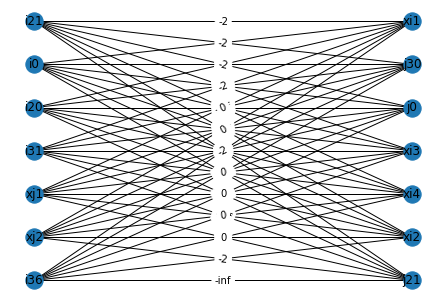

 (1, 27) deleted with cost 8, at budget 6
 algo2 cost of (1, 27): 5
 algo2 cost of (20, 30): 3
 algo2 cost of (1, 27): 5
 algo2 cost of (20, 30): 7
 algo2 cost of (1, 27): 8
 edge -> weight : (1, 17) - 6
 edge -> weight : (12, 39) - 6
 edge -> weight : (12, 32) - 6
 edge -> weight : (27, 37) - 6
 edge -> weight : (13, 23) - 6
 edge -> weight : (5, 17) - 6
 edge -> weight : (5, 12) - 6
 edge -> weight : (10, 12) - 6
 edge -> weight : (7, 20) - 6
 edge -> weight : (9, 32) - 6
 edge -> weight : (4, 12) - 6
 edge -> weight : (8, 20) - 6
 edge -> weight : (18, 27) - 6
 edge -> weight : (8, 27) - 6
 edge -> weight : (9, 18) - 6
 edge -> weight : (8, 21) - 6
 edge -> weight : (0, 7) - 6
 edge -> weight : (4, 21) - 6
 edge -> weight : (24, 36) - 6
 edge -> weight : (5, 32) - 6
 edge -> weight : (19, 38) - 6
 edge -> weight : (20, 21) - 6
 edge -> weight : (20, 25) - 6
 edge -> weight : (18, 20) - 6
 edge -> weight : (12, 37) - 6
 edge -> weight : (5, 29) - 6
 edge -> weight : (5, 30) - 6
 edge

In [21]:
# Benchmark Graph

n = 40
k = 3
kk = 4
p = 12

print(f"n {n}")
print(f"k {k}")

G = nx.watts_strogatz_graph(n,kk,p,seed=10)
pos = nx.circular_layout(G)
nx.draw(G,with_labels=True,font_weight='bold',pos=pos)
plt.show()

Ef = nx.Graph()
Ef.add_nodes_from(G.nodes())

print(f" Edges prior : {(n**2-n)/2}")

P1,P_stack1,count1 = Algorithm1(G,k)
P2,P_stack2,Pbar,count2 = Algorithm2(G,k)

if not len(P1.edges()) == len(P2.edges()):
    p1 = set(P1.edges())
    p2 = set(P2.edges())
    s = p1.symmetric_difference(p2)
    print(s)
    print(p1.difference(p2))
    print(p2.difference(p1))
    print(len(P1.edges()))
    print(len(P2.edges()))
    raise Exception("Refinement logic broken")

if not len(P1.edges()) == len(P_stack1):
    raise Exception("P1 not synced with P_stack1")

print(f" algo1 edges remaining: {len(P1.edges())}")

print(f" algo1 matchings performed: {count1}\n")

if not len(P2.edges()) == len(P_stack2):
    raise Exception("P2 not synced with P_stack2")


print(f" algo2 edges remaining {len(P2.edges())}")

print(f" algo2 matchings performed: {count2} ")

print(f" difference {abs(count1 - count2)}")


# Data Generation

#  - - - - - Comparison of Edges Killed - - - - - 